# Occupational Mobility Network Replication with German Labor Market Data

*Setup from @rmaria del rio-chanona et al. 2021*
*Code: @ebbamark (verified against code from MdRC's Zenodo repository: https://zenodo.org/record/4305783)*

The following script is a training attempt at implementing/replicating the Occupational Mobility Network model as presented in del Rio-Chanona et al. 2021. The code was written independtly and later compared to the publicly available code from the authors on Zenodo. The current stylized “toy” economy consists of six regions that vary in occupational diversity and population size. There are a total of 106 occupations (based on transition matrix from German labour market data) with occupation-specific constant target demand. Size and occupation diversity is currently varied as in the network graph below (3 possible sizes and 3 different rates of occupational diversity). It can be adapted to the country context from which we will draw our employment data. As you will see, many of these parameters are nonsensical at the moment and not calibrated on real-world data (only real-world data used to calibrate so far is the transition matrix). The graphs at the end of the document show indicators of interest across the 200 time periods through which the model is run.

Possible next steps:
* Induce shocks through target demand
    * Occupation-specific shock
        * Abundant occupation
        * Scarce/isolated occupation
        * Geo-occupation specific shock
    * Compare shock response between different network structures (occupational network vs. geographically embedded network with perfect mobility vs. occupational network with imperfect mobility)
    * Allow economy-wide labour demand to vary in response to shocks (currently this is constant impacted only by node-specific target demand reductions)

In [4]:
# Import packages
import numpy as np
import pandas as pd
from random import sample
import matplotlib.pyplot as plt
from IPython import display

path = "~/Documents/Documents - Nuff-Malham/GitHub/Green_Transition_ABM/rep_ebba/"

### Toy Economy Structure
The network graph below displays the regions in the toy economy. Each node represents a region in the economy. Node size represents population size. Node colour represents occupational diversity (yellow = most diverse; green = medium diverse; purple = least diverse). Labelled edges represent the respective distance metric between the regions (for now this is a scaling factor). Self-loop edge has a weight of 1.

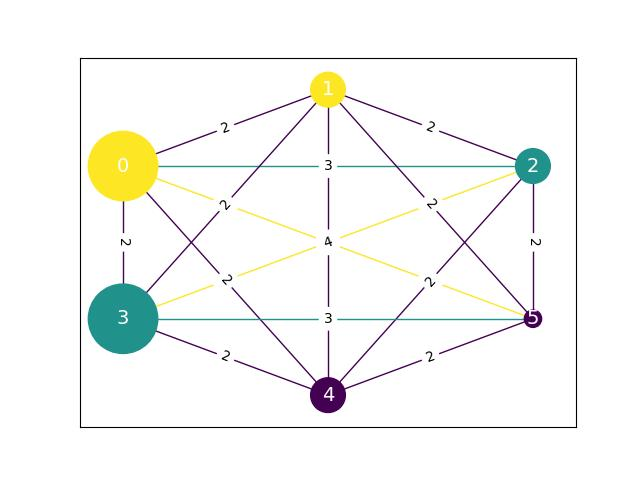

In [5]:
display.Image("network_graph.jpg")

### Data, Classes & Model Run

In [6]:
# Import information about relevant files to employment/unemployment, target demand, vacancies, etc.
# Transition matrix provided by Eric Klemm at UCL
A2 = pd.read_csv(path + 'data/transitionmatrix_v2.csv', delimiter=';', decimal=',', header = None, nrows = 106).dropna(axis= 'columns', how='all')

# Initialise with 6 geographies that have same characteristics as in toy model
geo = pd.read_csv(path+"data/geog_matrix.csv", delimiter=';', header=None)

# For now, initialise with identical employment, unemployment, vacancies, target_demand parameters
employment = pd.DataFrame(1000, columns = ['Employment'], index=range(106))
unemployment = pd.DataFrame(50, columns = ['Unemployment'], index=range(106))
vacancies = pd.DataFrame(100, columns = ['Vacancies'], index=range(106))
demand_target = pd.DataFrame(employment.to_numpy() + vacancies.to_numpy())

In [7]:
## Defining classes
# Potentially redundant use of IDs in the below classes...to check
class worker:
    def __init__(worker_id, go_id, occupation_id, geo_id, employed, longterm_unemp, time_employed, time_unemployed):
        worker_id.go_id = go_id
        worker_id.occupation_id = occupation_id
        worker_id.geo_id = geo_id
        worker_id.employed = employed
        worker_id.longterm_unemp = longterm_unemp
        worker_id.time_employed = time_employed
        worker_id.time_unemployed = time_unemployed

class occ_geo:
    def __init__(occ_id, _id, occupation_id, geo_id, list_of_workers, list_of_neigh_bool, list_of_neigh_weights, n_vacancies, hired_t, current_demand, target_demand, applicants):
        occ_id._id = _id
        occ_id.occupation_id = occupation_id
        occ_id.geo_id = geo_id
        occ_id.list_of_workers = list_of_workers
        occ_id.list_of_neigh_bool = list_of_neigh_bool
        occ_id.list_of_neigh_weights = list_of_neigh_weights
        occ_id.n_vacancies = n_vacancies
        occ_id.hired_t = hired_t
        occ_id.current_demand = current_demand
        occ_id.target_demand = target_demand
        occ_id.applicants = applicants

In [8]:
### Function and condition to initialise network

# Region size: Relative sizes of each region
size_scale = [2, 1, 1, 2, 1, 1/2]
# Economic diversity: no of occupations per region
# For now this is initialised to a value of how many occupations of 106 possible occupations to include in a region
# This can be randomized but perhaps best to maintain control of them for now to interpret impacts
divers_scale = [100, 100, 75, 75, 50, 50]

def initialise(n_occ, n_regions, employment, unemployment, vacancies, demand_target, A):
    """ Makes a list of occupations with initial conditions
       Args:
           n_occ: number of occupations initialised
           n_regions: number of regions initialised
           employment: vector with employment of each occupation
           unemployment: vector with unemployment of each occupation
           vacancies: vector with vacancies of each occupation
           demand_target: vector with (initial) target_demand for each occupation (never updated)
           A: adjacency matrix of network (not including auto-transition probability)

       Returns:
            occupations: list of occupations with above attributes
       """
    geo_occs = []
    ids = 0
    for k in range(n_regions):
        scale = size_scale[k]
        # creating occupation i in geo k multiplied by relative size of geo k
        smpls = sorted(sample(range(106), divers_scale[k]))
        for i in range(0, n_occ):
            if i in smpls:
                occ = occ_geo(ids, i, k, [], A[i] > 0, A[i], vacancies.iat[i,0]*scale, 0, (employment.iat[i,0] + vacancies.iat[i,0])*scale, demand_target.iat[i,0]*scale, [])
                # creating the workers of occupation i and attaching to occupation
                ## adding employed workers
                for w in range(round(employment.iat[i,0] * scale)):
                    # Assume they have all at least 1 t.s. of employment
                    occ.list_of_workers.append(worker(occ._id, i,  k, True, False, 1, 0))
                ## adding unemployed workers
                # Could consider adding random initial unemployment durations...for now no one becomes longterm unemployed until 6 time steps in
                for w in range(round(unemployment.iat[i,0] * scale)):
                        # Assume they have 1 t.s. of unemployment (so that they can apply for work)
                    occ.list_of_workers.append(worker(occ._id, i, k, False, False, 0, 1))
            else:
                occ = occ_geo(ids, i, k, [], A[i] > 0, A[i], 0, 0, 0, 0, [])
            geo_occs.append(occ)
            ids += 1
    return geo_occs

# Define network shock functions:\n",
def reskill(trans_mat):
    print("hello")

In [9]:
########################
# RUN THE MODEL ########
########################

T = 200
delta_u = 0.08
delta_v = 0.06
gamma_u = gamma_v = gamma = 0.032
r = 0.55

# Initialise occupational mobility network
net = initialise(len(A2), len(geo), employment, unemployment, vacancies, demand_target, A2)

# Records variables of interest
record = pd.DataFrame(columns=['Time', 'Occ_Geo_ID', 'Geo_ID', 'Occupation_ID', 'Workers', 'Employment', 'Unemployment', 'Vacancies', 'LT_Unemployed'])

for t in range(T):
    # print("TIME: ", t)
    # Preliminary attempt at impacting target_demand
    #if(t == 75):
    #    net[27].target_demand = int(net[27].target_demand/10)
    for occ in net:
        ### SEPARATIONS
        # Not yet specific to region - only occupation
        # Only take this step if there are workers in the geo_occ (ie. occupation is present in geo)
        #       Could become a problem if an area's occupation shuts down at some point - but is arguably consistent
        if(len(occ.list_of_workers) != 0):
            sep_prob = delta_u + gamma * max(0, occ.current_demand - occ.target_demand)/sum(wrkr.employed for wrkr in occ.list_of_workers)
            emp = [el for el in occ.list_of_workers if el.employed]
            for w in sample(emp, np.random.binomial(len(emp), sep_prob)):
                w.employed = False
                w.longterm_unemp = False
                w.time_employed = 0
                w.time_unemployed = 0

            ### HIRING
            if (occ.n_vacancies > 0) and (len(occ.applicants) > 0):
                for a in sample(occ.applicants, min(int(occ.n_vacancies), len(occ.applicants))):
                    if a.go_id == occ._id:
                        occ.list_of_workers[occ.list_of_workers.index(a)].employed = True
                        occ.list_of_workers[occ.list_of_workers.index(a)].longterm_unemp = False
                        occ.list_of_workers[occ.list_of_workers.index(a)].time_employed = 0
                        occ.list_of_workers[occ.list_of_workers.index(a)].time_unemployed = 0
                        occ.hired_t += 1

                    else:
                        occ.list_of_workers.append(net[a.go_id].list_of_workers.pop(net[a.go_id].list_of_workers.index(a)))
                        a.go_id = occ._id
                        a.occupation_id = occ.occupation_id
                        a.geo_id = occ.geo_id
                        a.employed = True
                        a.longterm_unemp = False
                        a.time_employed = 0
                        a.time_unemployed = 0
                        occ.hired_t += 1
            else:
                pass

            # Applicants have either been rejected or accepted - list cleared
            occ.applicants.clear()
            assert(len(occ.applicants) == 0)

            ### APPLICATIONS
            # Applicants apply based on vacancies from previous period (agreed with Jonas - now wondering if unrealistic? - applying to ancient vacancies)
            # Now calculated at the END of previous period which seems appropriate
            # CANNOT be fired and apply in same time step ie. time_unemployed > 0
            # CAN be rejected and apply in the same time step - no protected attribute
            unemp = [el for el in occ.list_of_workers if not(el.employed) and el.time_unemployed > 0]
            # Transition probabilities
            # Note that the below is not dynamic now - need to be precise about repeating geo matrix for each of the 106 occs
            num = np.array([occ.n_vacancies for occ in net]) * (np.tile(A2[occ.occupation_id], (1,6)) / np.repeat(np.array(geo)[occ.geo_id], repeats = 106, axis = 0))
            # Scale by number of workers making an application (rowsum == len(unemp)
            trans = np.round((num / np.sum(num)) * len(unemp))
            k = 0
            for row in range(trans.size):
                # Extend the relevant number of applicants to the relevant occupation
                net[row].applicants.extend(unemp[k:k + int(trans[0,row])])
                k += (int(trans[0,row]))

            for p in occ.list_of_workers:
                # Change times employed and unemployed as well as logical for long term unemployed
                if p.employed:
                    p.time_employed += 1
                if not(p.employed):
                    p.time_unemployed += 1
                    p.longterm_unemp = True if p.time_unemployed >= 7 else False

    # Update vacancies after all shifts have taken place
    for occ in net:
        if (len(occ.list_of_workers) != 0):
            ### VACANCIES
            emp = sum(wrkr.employed for wrkr in occ.list_of_workers)
            # Conditional on vacancies AFTER hiring workers (Correct?)
            occ.current_demand = occ.n_vacancies - occ.hired_t + emp
            vac_prob = delta_v + ((1 - delta_v) * (gamma * max(0, occ.target_demand - occ.current_demand))) / emp
            occ.n_vacancies += int(np.random.binomial(emp, vac_prob)) - occ.hired_t
            occ.hired_t = 0

        # Record of indicators of interest (geo_occ, geo, occ, # workers, employed, unemployed, vacancies, long_term_unemployed)
        record.loc[len(record)]= [t,
                   occ._id,
                   occ.geo_id,
                   occ.occupation_id,
                   len(occ.list_of_workers),
                   sum(wrkr.employed for wrkr in occ.list_of_workers),
                   sum(not(wrkr.employed) for wrkr in occ.list_of_workers),
                   occ.n_vacancies,
                   sum(wrkr.longterm_unemp for wrkr in occ.list_of_workers)]

print("Done after ", t + 1, " time steps.")

Done after  200  time steps.


### Results

In [10]:
# Results specifications (whether to save as final or not)
final = False
figpath = "~/Documents/Documents - Nuff-Malham/GitHub/Green_Transition_ABM/rep_ebba/output"

#### Overall Economy: Employment, Unemployment, Worker, Vacancy, and Longterm Employed Levels

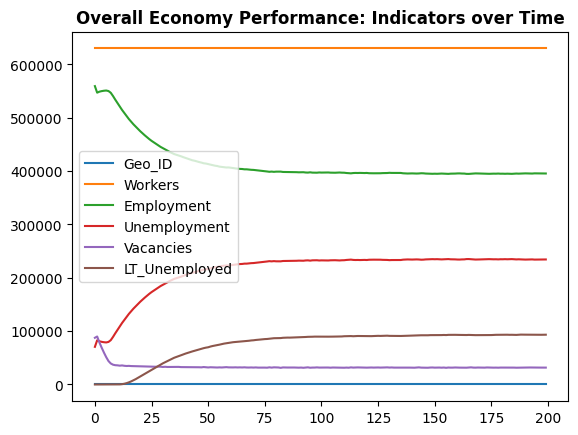

In [11]:
# Indicators in overall economy
totals = record.loc[:,['Time', 'Geo_ID', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT_Unemployed']].groupby(['Time']).sum()
lgd = []
for column in totals[1:]:
    plt.plot(totals[column])
    lgd.append(column)
plt.title("Overall Economy Performance: Indicators over Time", fontweight = 'bold')
plt.legend(list(lgd), loc="center left", ncol=1)
if final:
    plt.savefig(figpath+'overall_economy.jpg', dpi = 300)
else:
    plt.show()
plt.close()

#### Long-term unemployment rate and levels

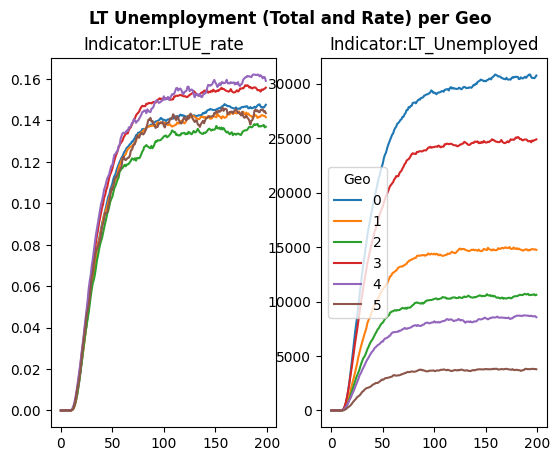

In [12]:
# LT Unemployed per geography

fig = plt.figure(constrained_layout = False)
ltue = record.loc[:,['Time', 'Geo_ID', 'Workers', 'LT_Unemployed']].groupby(['Time', 'Geo_ID']).sum().reset_index()
ltue['LTUE_rate'] = ltue['LT_Unemployed'] / ltue['Workers']
lgd = []
# #ltue.set_index('Time', inplace=True)
# #plt.plot(ltue.groupby('Geo_ID')['LTUE_rate'])
for i, ind in enumerate(['LTUE_rate', 'LT_Unemployed']):
    fig.add_subplot(1, 2, i+1, title=f'Indicator:{ind}')
    for g in np.unique(ltue.Geo_ID):
        temp = ltue[(ltue['Geo_ID'] == g)][[ind, 'Time']]
        plt.plot(temp['Time'], temp[ind])
        lgd.append(int(g))
plt.suptitle("LT Unemployment (Total and Rate) per Geo", fontweight = 'bold')
plt.legend(list(lgd), loc="center left", ncol=1, title = "Geo")
if final:
    plt.savefig(figpath+'ltuer_geo.jpg', dpi = 300)
else:
    plt.show()
plt.close(fig)

#### Geographies: Employment, Unemployment, Worker, Vacancy, and Longterm Employed Levels

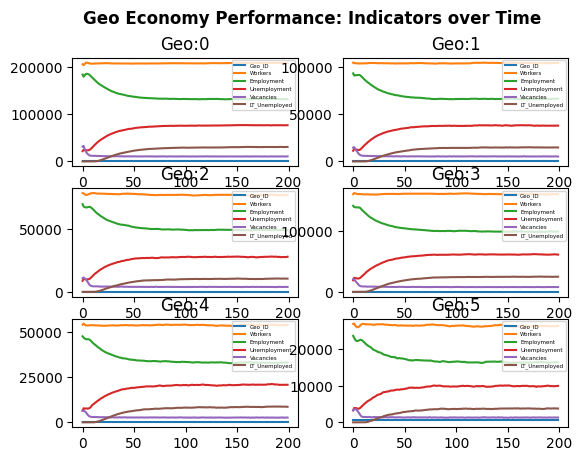

In [13]:
# Overall indicators per geography (sum of indicators in all occupations)
ids = np.unique(record.Geo_ID)
fig = plt.figure(constrained_layout = False)

geo_totals = record.loc[:,['Time', 'Geo_ID', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT_Unemployed']]
for g in ids:
    gtmp = geo_totals[(geo_totals['Geo_ID'] == g)].loc[:, ['Time', 'Geo_ID', 'Workers', 'Employment', 'Unemployment', 'Vacancies', 'LT_Unemployed']].groupby(['Time']).sum()
    # Indicators (workers, employment, etc)
    fig.add_subplot(3, 2, int(g)+1, title = f'Geo:{int(g)}')
    lgd = []
    for column in gtmp[1:]:
        plt.plot(gtmp[column])
        lgd.append(column)
    plt.legend(list(lgd), loc='upper right', ncols = 1, title_fontsize = "6", fontsize="4")
fig.suptitle("Geo Economy Performance: Indicators over Time", fontweight = 'bold')
if final:
    plt.savefig(figpath+'geo_econ_perf.jpg', dpi = 300)
else:
    plt.show()
plt.close(fig)

#### Occupational Performance per Geography: Employment, Unemployment, Worker, Vacancy, and Longterm Employed Levels

Horribly difficult to read at the moment.

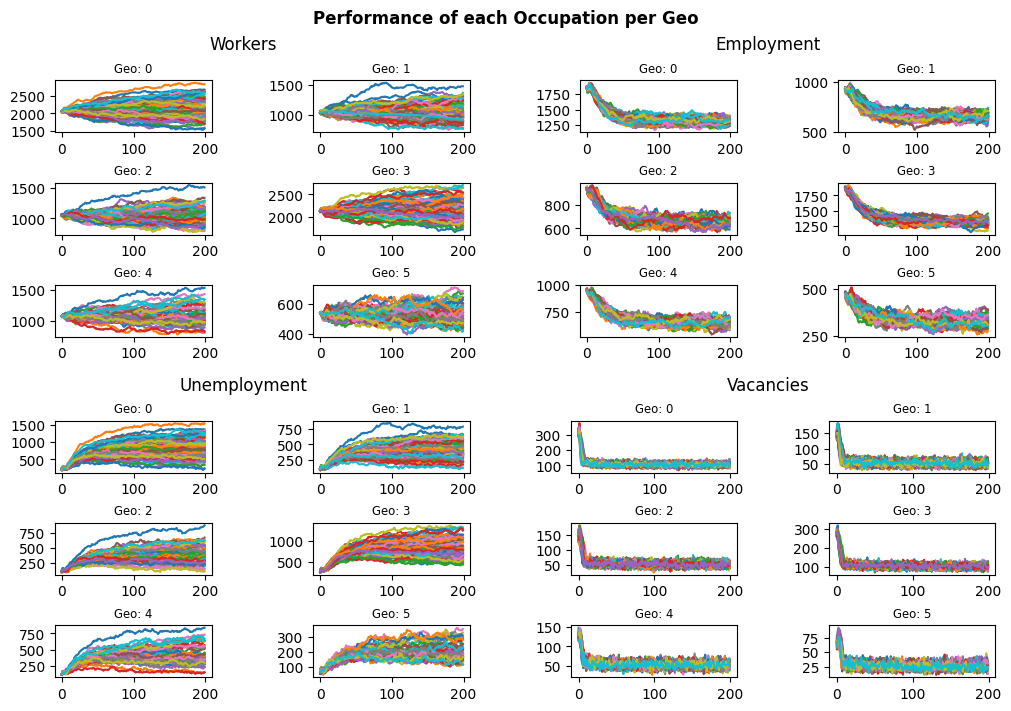

In [14]:
# Each indicator by Geo
inds = record.columns[4:9]
ids = np.unique(record.Occupation_ID)

fig = plt.figure(constrained_layout = True, figsize = (10,7))
subfigs = fig.subfigures(2, 2)

labels = [f"{i}" for i in range(int(min(ids)),int(max(ids)) + 1)]
for outerind, subfig in enumerate(subfigs.flat):
    rec = record[['Time', 'Geo_ID', 'Occupation_ID', record.columns[outerind + 4]]]
    # Indicators (workers, employment, etc)
    subfig.suptitle(f'{record.columns[outerind + 4]}')
    axs = subfig.subplots(3, 2)
    # Each geo
    for innerind, ax in enumerate(axs.flat):
        tmp = rec[(rec['Geo_ID'] == innerind)].pivot(index='Time', columns='Occupation_ID', values=record.columns[outerind + 4])
        for i, lb in enumerate(labels):
            if (sum(tmp[i])) > 0:
                ax.plot(tmp[i], label = lb)
        ax.set_title(f'Geo: {innerind}', fontsize='small')
    #subfig.legend(labels = labels, loc='upper right', title = "Occ_ID", ncols = 1, bbox_to_anchor=(0, 0), title_fontsize = "8", fontsize="6")
fig.get_layout_engine().set(wspace=0.1)
fig.suptitle("Performance of each Occupation per Geo", fontweight = 'bold')
if final:
    plt.savefig(figpath+'occ_perf_per_geo.jpg', dpi = 300)
else:
    plt.show()

plt.close(fig)